In [1]:
import os
import sys
from tqdm import tqdm
from datetime import datetime
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.data import Data, Batch

In [2]:
# Create submission folder if it doesn't exist
submission_dir = './submission'
os.makedirs(submission_dir, exist_ok=True)

# Uncomment the following block ONLY if you wish to inspect file paths in a Kaggle-like directory structure.
# On your local system, you likely have the files in your local folder so this is not needed.
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Data Loading for Local Environment
# Files are assumed to be in:
# ./cse-251-b-2025/train.npz
# ./cse-251-b-2025/test_input.npz

train_file = np.load("./cse-251-b-2025/train.npz")
train_data = train_file['data']
print("train_data's shape:", train_data.shape)  # Expected shape: (10000, 50, 110, 6)

test_file = np.load("./cse-251-b-2025/test_input.npz")
test_data = test_file['data']
print("test_data's shape:", test_data.shape)    # Expected shape: (2100, 50, 50, 6)

train_data's shape: (10000, 50, 110, 6)
test_data's shape: (2100, 50, 50, 6)


# Visualization: 

In [3]:
# Run visualizations?
run_visualizations: bool = False

# From data loading notebook
def plot_one_training_scene(idx: int = 0):
    # Plot trajectories from one training scene (static plot)
    data_matrix = train_data[idx]

    plt.figure(figsize=(8, 8))
    for agent in range(data_matrix.shape[idx]):
        xs = data_matrix[agent, :, 0]
        ys = data_matrix[agent, :, 1]
        # Remove zeros (padding)
        xs = xs[xs != 0]
        ys = ys[ys != 0]
        plt.plot(xs, ys, alpha=0.7)
    plt.title("Trajectories from one training scene")
    plt.xlabel("x-coordinate")
    plt.ylabel("y-coordinate")
    plt.show()

# Create an animated gif for one training scene (exact code provided on kaggle)
def make_gif(data_matrix, name='example'):
    cmap = None
    if sys.version_info.minor <= 7:
        cmap = plt.cm.get_cmap("viridis", 50)
    else:
        cmap = plt.get_cmap("viridis", 50)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Function to update plot for each frame
    def update(frame):
        ax.clear()
        # Get data for current timestep
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]  # Include current frame
                ys = data_matrix[i, :frame+1, 1]  # Include current frame
                # trim all zeros
                mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
                xs = xs[mask]
                ys = ys[mask]
                # Only plot if we have points to plot
                if len(xs) > 0 and len(ys) > 0:
                    color = cmap(i)
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1],
                color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1],
                   s=80, color='tab:orange')
        # Set title with timestep
        ax.set_title(f'Timestep {frame}')
        # Set consistent axis limits
        ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, 
                    data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, 
                    data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
        ax.legend()
        return ax.collections + ax.lines

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    # Save as GIF
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

if run_visualizations:
    plot_one_training_scene(0)
    make_gif(train_data[0], 'index0')

# Constant velocity from test set
Untouched from original data loading notebook.

In [4]:
# Run constant velocity model (Kaggle score of ~50)?
run_constant_velocity_model: bool = False

if run_constant_velocity_model:
    # Compute the velocity differences for the ego vehicle (agent index 0)
    velocity_diff = test_data[..., 1:, :2] - test_data[..., :-1, :2]
    print("Velocity difference shape:", velocity_diff.shape)

    # Compute average velocity for the ego vehicle (index 0) in each scene
    constant_vel = np.mean(velocity_diff[:, 0, :, :], axis=1)
    print("Constant velocity shape:", constant_vel.shape)

    # Generate predictions for 60 future time steps based on constant velocity
    pred_y_const = np.zeros((test_data.shape[0], 60, 2))
    starting_point = test_data[:, 0, -1, :2]  # Last observed position of ego vehicle

    for t in range(60):
        pred_y_const[:, t, :] = starting_point + (t + 1) * constant_vel

    # Reshape predictions to submission format: (2100, 60, 2) -> (12600, 2)
    pred_output_const = pred_y_const.reshape(-1, 2)
    output_df_const = pd.DataFrame(pred_output_const, columns=['x', 'y'])
    output_df_const.index.name = 'index'
    # Save output in the submission folder
    constant_vel_path = os.path.join(submission_dir, 'constant_vel_submission.csv')
    output_df_const.to_csv(constant_vel_path)
    print(f"Constant velocity submission saved locally as '{constant_vel_path}'.")

# Our Work

In [5]:
# MLP model with residual blocks: ineffective for TimeSeries data
class BasicMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()

        # Lazy layers infer the input size instead of having to explicitly pass it in
        # Backbone: linear -> BatchNorm -> PReLU -> Dropout
        self.net = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(0.2),
        ) # Note: residual width must match the last width of the net

        # Residual block added to avoid vanishing gradient issue
        self.residual = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(256),
        )

        # Infer last input shape, then do final projection (60*2)
        self.head = nn.LazyLinear(output_features)

    def forward(self, x):
        # Original forward loop
        # # (batch, 50, 50, 6) or flattened already
        # x = x.view(x.size(0), -1)
        # h = self.net(x) #(batch, 256)
        # h = h + self.residual(h)  # residual skip
        # return self.head(h) #(batch, 120)

        # Taken from milestone notebook (tensor format)
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.net(x)
        x = x + self.residual(x)
        x = self.head(x)
        return x.view(-1, 60, 2)

In [6]:
# Base LSTM given to us in the milestone notebook
class BaseLSTM(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(BaseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [7]:
# Multi agent scene context model
class SceneContextModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.agent_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.ego_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 60 * 2)
        )

    def forward(self, x_flat):
        # x = data.x
        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        # x = x.reshape(-1, 50 * 50 * 6)
        # x = self.mlp(x)
        # return x.view(-1, 60, 2)
        # In case you passed in a DataBatch
        if not isinstance(x_flat, torch.Tensor):
            x_flat = x_flat.x

        B = x_flat.size(0)
        x = x_flat.view(B, 50, 50, 6) #(B, agents, timesteps, features)
        x_agents = x.view(B, 50, -1)  #(B, 50, 300)
        agent_feats = self.agent_encoder(x_agents) #(B, 50, hidden_dim)
        scene_context = agent_feats.mean(dim=1) #(B, hidden_dim)

        ego_input = x[:, 0, :, :].reshape(B, -1) #(B, 300)
        ego_feat = self.ego_encoder(ego_input) #(B, hidden_dim)

        combined = torch.cat([ego_feat, scene_context], dim=1)

        out = self.decoder(combined) #(B, 120)
        return out.view(-1, 60, 2)

In [8]:
# Extended from the base LSTM model
class LSTMWithMLP(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(LSTMWithMLP, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.fc = nn.Linear(128, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        x = self.net(lstm_out[:, -1, :])
        x = self.fc(x)
        return x.view(-1, 60, 2)

# Preparing data

`TrajectoryDataset*` are taken from the milestone notebook.

In [9]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                # future = future @ R gives DeprecationWarning: future a torch.Tensor
                future = torch.from_numpy(np.dot(future.numpy(), R)) 
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin -> same DeprecationWarning
        future = torch.from_numpy(future.numpy() - origin)

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

# Training loop

Change which model is used at the `model = ...(input_features, output_features)` line.

Change which optimizer is used at the `optimizer = optim...` line.

Do **NOT** change the `criterion`, as MSE is stated in the Data tab of the competition.

In [10]:
# Taken from milestone notebook
# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [11]:
# Functions to save and load the model (should correspond to what was trained!)
def save_model(model, path="our_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def load_model(model_instance, path="our_model.pth"):
    loaded_model = model_instance
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model


# Example usage:
# save_model(trained_model)
# model = load_model()

In [12]:
def get_timestamp() -> str:
    return datetime.now().strftime("%Y-%m-%d_%I-%M%p")

In [51]:
# Calculate number of input features after flattening and number of output features
# Note: LSTM models take features in different dimensions
input_features:int = 50 * 50 * 6   # 50 agents, 50 time steps, 6 dimensions each (15000 input features)
output_features:int = 60 * 2       # 60 future time steps, 2 dimensions (x, y) (120 output features)

# Hyperparameters
batch_size: int = 64
num_folds: int = 4
early_stopping_patience: int = 30
early_stopping_threshold: float = 1e-4
epochs: int = 250
starting_lr: float = 1e-2
scale: float = 7.0
weight_decay: float = 1e-2

lstm_hidden_dim: int = 256

# IMPORTANT! To change which model is used: comment/uncomment below
# Easily swap models by changing what is returned (called in training and test to avoid conflicts)
def get_model():
    # return BasicMLP(input_features, output_features).to(device)
    # return BaseLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    return SceneContextModel(hidden_dim=864).to(device)
    # return LSTMWithMLP(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)

SEED: int = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

def train_model(full_training_data: np.ndarray, 
                batch_size:int = 64, epochs:int = 10, num_folds:int = 5,
                early_stopping_patience:int = 5, early_stopping_threshold:float = 1e-3):
    global starting_lr, gamma, scale, lstm_hidden_dim, output_features, weight_decay

    # Time series data needs to keep its data in relative order, so no shuffling can occur
    #   like in regular KFold cross validation
    splitter = TimeSeriesSplit(n_splits=num_folds)

    # Perform cross-validation, the best model will be saved as "best_model.pt" to be loaded in later
    overall_best_val_loss = float("inf")

    # Resources used:
    # Project milestone notebook
    # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
    # https://www.geeksforgeeks.org/time-series-cross-validation/
    for fold_i, (train_idx, val_idx) in enumerate(splitter.split(full_training_data)):
        print(f"\nFOLD {fold_i + 1}/{num_folds} ==================================")

        # Create the model, loss criterion, and optimizer (reset per fold, to find the best model)
        # If you change the model here, ensure its the same in the test loop!
        # DO NOT CHANGE CRITERION
        criterion = nn.MSELoss()

        model = get_model()
        optimizer = optim.AdamW(model.parameters(), lr=starting_lr, weight_decay=weight_decay)
        schedulers: list[lr_scheduler.LRScheduler] =[
            lr_scheduler.ExponentialLR(optimizer, gamma=0.995),
            lr_scheduler.MultiStepLR(
                optimizer,
                milestones= list(range(25, epochs, 25)),
                gamma=0.75,
            ),
            # lr_scheduler.MultiStepLR(
            #     optimizer,
            #     milestones= list(range(100, epochs, 100)),
            #     gamma=0.5,
            # ),
            lr_scheduler.CosineAnnealingLR(
                optimizer, 
                T_max= int(epochs * 0.9),
                eta_min=1e-5
            ),
        ]

        # Prepare data from this fold
        train_fold: np.ndarray = full_training_data[train_idx]
        val_fold: np.ndarray = full_training_data[val_idx]
        collate_func = None     # Optional for DataLoader, taken from milestone notebook
        if not isinstance(model, SceneContextModel):
            # LSTM can handle the timeseries data directly
            # TrajectoryDataset expects numpy arrays
            collate_func = lambda x: Batch.from_data_list(x)
            train_dataset = TrajectoryDatasetTrain(train_fold, scale=scale, augment=True)
            val_dataset = TrajectoryDatasetTrain(val_fold, scale=scale, augment=False)
        else:
            train_x: np.ndarray = train_fold[..., :50, :]
            train_y: np.ndarray = train_fold[:, 0, 50:, :2]
            X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
            y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

            val_x: np.ndarray = val_fold[..., :50, :]
            val_y: np.ndarray = val_fold[:, 0, 50:, :2]
            X_val_tensor = torch.FloatTensor(val_x).reshape((-1, input_features))
            y_val_tensor = torch.FloatTensor(val_y).reshape((-1, output_features))
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_func)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

        best_val_loss: float = float("inf")
        no_improvement: int = 0

        # Training and validation loops are taken from the milestone notebook,
        #   with modifications to allow for different data loading shapes      
        for epoch in tqdm(range(epochs), desc="Epoch", unit="epoch"):
            # Training loop
            model.train()
            train_loss = 0
            for batch in train_dataloader:
                batch_x = None
                batch_y = None
                if isinstance(batch, tuple) or isinstance(batch, list):
                    batch_x, batch_y = batch
                    batch_y = batch_y.view(-1, 60, 2)
                else: # DataBatch type
                    batch = batch.to(device)
                    batch_x = batch.x
                    batch_y = batch.y.view(batch.num_graphs, 60, 2)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                optimizer.step()
                train_loss += loss.item()

            # Validation loop
            model.eval()
            val_loss = 0
            val_mae = 0
            val_mse = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch_x = None
                    batch_y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        batch_x, batch_y = batch
                        batch_y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        batch = batch.to(device)
                        batch_x = batch.x
                        batch_y = batch.y.view(batch.num_graphs, 60, 2)

                    pred = model(batch_x)
                    val_loss += criterion(pred, batch_y).item()

                    # show MAE and MSE with unnormalized data
                    y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                        y = batch_y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                    val_mae += nn.L1Loss()(pred, y).item()
                    val_mse += nn.MSELoss()(pred, y).item()

            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            val_mae /= len(val_dataloader)
            val_mse /= len(val_dataloader)

            if (epoch + 1) % 5 == 0:
                tqdm.write(f"Epoch {(epoch + 1):03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")

            if val_loss < best_val_loss - early_stopping_threshold:
                best_val_loss = val_loss
                no_improvement = 0

                # Better than the overall seen so far?
                if best_val_loss < overall_best_val_loss:
                    overall_best_val_loss = best_val_loss
                    torch.save(model.state_dict(), "best_model.pt")
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    print(f"==== EARLY STOP at epoch {(epoch + 1):03d}")
                    break

            for sched in schedulers:
                sched.step()


# Load in the model saved during testing to use on X_test
# Mostly taken from milestone notebook
def predict(X_test: np.ndarray, best_model_path: str = "best_model.pt"):
    global scale, batch_size, lstm_hidden_dim, output_features

    # Ensure this aligns with the trained model!
    best_model = torch.load(best_model_path)
    model = get_model()
    model.load_state_dict(best_model)
    model.eval()

    pred_list = []
    with torch.no_grad():
        if not isinstance(model, SceneContextModel): # Using DataBatch type from a DataLoader
            collate_func = lambda x: Batch.from_data_list(x)
            test_dataset = TrajectoryDatasetTest(X_test, scale=scale)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

            for batch in test_loader:
                batch = batch.to(device)
                pred_norm = model(batch.x)

                # Reshape the prediction to (N, 60, 2)
                pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
                pred_list.append(pred.cpu().numpy())
        else:
            X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features)).to(device)
            pred = model(X_test_tensor).cpu().reshape((-1, 60, 2))
            pred_list.append(pred.numpy())

    # Reshape predictions to match submission format: (2100, 60, 2) -> (12600, 2)
    pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
    pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
    output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
    output_df.index.name = 'index'
    return output_df

# Train the model (tweak batch_size and epochs as needed at top of this block)
# Saved as "best_model.pt" to be loaded in during testing
train_model(train_data, batch_size=batch_size, epochs=epochs, num_folds=num_folds,
            early_stopping_patience=early_stopping_patience,
            early_stopping_threshold=early_stopping_threshold)

# Make predictions on the test set
model_predictions_df = predict(test_data)
assert len(model_predictions_df) == 126000, f"Incorrect number of rows in output, expected 126000, got {len(model_predictions_df)}"

# Save output in the submission foldder, timestamped!
submission_path = os.path.join(submission_dir, f"submission-{get_timestamp()}.csv")
model_predictions_df.to_csv(submission_path)
print(f"Submission saved locally as: '{submission_path}'.")


FOLD 1/4 ==================================


Epoch:   2%|▏         | 5/250 [00:04<03:46,  1.08epoch/s]

Epoch 005 | Learning rate 0.009794 | train normalized MSE 340011.1879 | val normalized MSE 176126.2485, | val MAE 276.0763 | val MSE 176126.2485


Epoch:   4%|▍         | 10/250 [00:09<03:35,  1.11epoch/s]

Epoch 010 | Learning rate 0.009521 | train normalized MSE 139414.3148 | val normalized MSE 43653.5620, | val MAE 130.6873 | val MSE 43653.5620


Epoch:   6%|▌         | 15/250 [00:21<08:44,  2.23s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE 71564.2681 | val normalized MSE 28848.8943, | val MAE  75.7169 | val MSE 28848.8943


Epoch:   8%|▊         | 20/250 [00:29<06:17,  1.64s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE 120353.3507 | val normalized MSE 149197.7125, | val MAE 216.1493 | val MSE 149197.7125


Epoch:  10%|█         | 25/250 [00:35<04:40,  1.25s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE 55660.7871 | val normalized MSE 39276.6014, | val MAE 120.6527 | val MSE 39276.6014


Epoch:  12%|█▏        | 30/250 [00:41<04:17,  1.17s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE 27739.2745 | val normalized MSE 36851.9702, | val MAE 126.4626 | val MSE 36851.9702


Epoch:  14%|█▍        | 35/250 [00:46<04:06,  1.15s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE 32424.0556 | val normalized MSE 15469.8858, | val MAE  54.4267 | val MSE 15469.8858


Epoch:  16%|█▌        | 40/250 [00:52<04:00,  1.14s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE 9078.2557 | val normalized MSE 15428.8523, | val MAE  87.9407 | val MSE 15428.8523


Epoch:  18%|█▊        | 45/250 [00:58<03:49,  1.12s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE 9940.9377 | val normalized MSE 7212.7513, | val MAE  54.6090 | val MSE 7212.7513


Epoch:  20%|██        | 50/250 [01:03<03:42,  1.11s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE 17134.7840 | val normalized MSE 8820.7477, | val MAE  62.3247 | val MSE 8820.7477


Epoch:  22%|██▏       | 55/250 [01:09<03:41,  1.14s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE 11728.8087 | val normalized MSE 17146.7799, | val MAE  83.9284 | val MSE 17146.7799


Epoch:  24%|██▍       | 60/250 [01:15<03:37,  1.15s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE 3229.0701 | val normalized MSE 2467.3437, | val MAE  34.9593 | val MSE 2467.3437


Epoch:  26%|██▌       | 65/250 [01:20<03:26,  1.11s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE 6353.1087 | val normalized MSE 5503.8351, | val MAE  48.8601 | val MSE 5503.8351


Epoch:  28%|██▊       | 70/250 [01:26<03:20,  1.11s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE 3480.1471 | val normalized MSE 2657.4520, | val MAE  39.1663 | val MSE 2657.4520


Epoch:  30%|███       | 75/250 [01:31<03:16,  1.12s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE 3086.3985 | val normalized MSE 1791.8820, | val MAE  22.4297 | val MSE 1791.8820


Epoch:  32%|███▏      | 80/250 [01:37<03:16,  1.16s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE 1813.8493 | val normalized MSE 2843.9059, | val MAE  34.4962 | val MSE 2843.9059


Epoch:  34%|███▍      | 85/250 [01:43<03:08,  1.14s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE 1708.1149 | val normalized MSE 996.4278, | val MAE  19.9849 | val MSE 996.4278


Epoch:  36%|███▌      | 90/250 [01:49<03:03,  1.14s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE 737.8540 | val normalized MSE 1628.2282, | val MAE  20.8107 | val MSE 1628.2282


Epoch:  38%|███▊      | 95/250 [01:54<02:57,  1.14s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE 753.0199 | val normalized MSE 974.8122, | val MAE  23.2013 | val MSE 974.8122


Epoch:  40%|████      | 100/250 [02:00<02:49,  1.13s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE 1122.7255 | val normalized MSE 756.1954, | val MAE  17.4979 | val MSE 756.1954


Epoch:  42%|████▏     | 105/250 [02:06<02:45,  1.14s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE 843.8843 | val normalized MSE 634.0867, | val MAE  18.5454 | val MSE 634.0867


Epoch:  44%|████▍     | 110/250 [02:11<02:39,  1.14s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE 377.2361 | val normalized MSE 373.5695, | val MAE  15.1322 | val MSE 373.5695


Epoch:  46%|████▌     | 115/250 [02:17<02:35,  1.15s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE 407.3099 | val normalized MSE 336.5883, | val MAE  13.5010 | val MSE 336.5883


Epoch:  48%|████▊     | 120/250 [02:23<02:26,  1.13s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE 272.7364 | val normalized MSE 209.4631, | val MAE  10.7011 | val MSE 209.4631


Epoch:  50%|█████     | 125/250 [02:28<02:21,  1.13s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE 312.7867 | val normalized MSE 160.5913, | val MAE   9.2505 | val MSE 160.5913


Epoch:  52%|█████▏    | 130/250 [02:34<02:16,  1.14s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE 180.4841 | val normalized MSE 141.2397, | val MAE   8.0594 | val MSE 141.2397


Epoch:  54%|█████▍    | 135/250 [02:40<02:11,  1.14s/epoch]

Epoch 135 | Learning rate 0.000431 | train normalized MSE 137.4091 | val normalized MSE 155.7596, | val MAE   8.8759 | val MSE 155.7596


Epoch:  56%|█████▌    | 140/250 [02:45<02:06,  1.15s/epoch]

Epoch 140 | Learning rate 0.000382 | train normalized MSE 171.4406 | val normalized MSE 127.6734, | val MAE   8.0433 | val MSE 127.6734


Epoch:  58%|█████▊    | 145/250 [02:51<02:01,  1.16s/epoch]

Epoch 145 | Learning rate 0.000336 | train normalized MSE 118.0002 | val normalized MSE 128.0972, | val MAE   8.1500 | val MSE 128.0972


Epoch:  60%|██████    | 150/250 [02:57<01:56,  1.16s/epoch]

Epoch 150 | Learning rate 0.000293 | train normalized MSE 102.8991 | val normalized MSE  89.3384, | val MAE   6.3092 | val MSE  89.3384


Epoch:  62%|██████▏   | 155/250 [03:03<01:50,  1.16s/epoch]

Epoch 155 | Learning rate 0.000191 | train normalized MSE  90.9531 | val normalized MSE 101.8607, | val MAE   7.0475 | val MSE 101.8607


Epoch:  64%|██████▍   | 160/250 [03:09<01:43,  1.15s/epoch]

Epoch 160 | Learning rate 0.000164 | train normalized MSE  85.6448 | val normalized MSE  89.0495, | val MAE   6.5117 | val MSE  89.0495


Epoch:  66%|██████▌   | 165/250 [03:14<01:38,  1.15s/epoch]

Epoch 165 | Learning rate 0.000139 | train normalized MSE  72.5812 | val normalized MSE  79.3390, | val MAE   5.7903 | val MSE  79.3390


Epoch:  68%|██████▊   | 170/250 [03:20<01:32,  1.15s/epoch]

Epoch 170 | Learning rate 0.000117 | train normalized MSE  73.1589 | val normalized MSE  76.2738, | val MAE   5.7130 | val MSE  76.2738


Epoch:  70%|███████   | 175/250 [03:26<01:25,  1.15s/epoch]

Epoch 175 | Learning rate 0.000097 | train normalized MSE  70.1858 | val normalized MSE  75.2157, | val MAE   5.8496 | val MSE  75.2157


Epoch:  72%|███████▏  | 180/250 [03:32<01:21,  1.17s/epoch]

Epoch 180 | Learning rate 0.000060 | train normalized MSE  63.6390 | val normalized MSE  69.1499, | val MAE   5.4264 | val MSE  69.1499


Epoch:  74%|███████▍  | 185/250 [03:37<01:15,  1.16s/epoch]

Epoch 185 | Learning rate 0.000049 | train normalized MSE  61.1438 | val normalized MSE  69.5232, | val MAE   5.4672 | val MSE  69.5232


Epoch:  76%|███████▌  | 190/250 [03:43<01:10,  1.17s/epoch]

Epoch 190 | Learning rate 0.000039 | train normalized MSE  59.8573 | val normalized MSE  64.7313, | val MAE   5.1273 | val MSE  64.7313


Epoch:  78%|███████▊  | 195/250 [03:49<01:04,  1.16s/epoch]

Epoch 195 | Learning rate 0.000031 | train normalized MSE  58.8917 | val normalized MSE  66.1552, | val MAE   5.3275 | val MSE  66.1552


Epoch:  80%|████████  | 200/250 [03:55<00:58,  1.18s/epoch]

Epoch 200 | Learning rate 0.000024 | train normalized MSE  56.7547 | val normalized MSE  64.0506, | val MAE   5.0795 | val MSE  64.0506


Epoch:  82%|████████▏ | 205/250 [04:01<00:52,  1.17s/epoch]

Epoch 205 | Learning rate 0.000015 | train normalized MSE  55.8701 | val normalized MSE  62.6951, | val MAE   4.9774 | val MSE  62.6951


Epoch:  84%|████████▍ | 210/250 [04:07<00:46,  1.16s/epoch]

Epoch 210 | Learning rate 0.000013 | train normalized MSE  55.9967 | val normalized MSE  63.4049, | val MAE   5.0245 | val MSE  63.4049


Epoch:  86%|████████▌ | 215/250 [04:12<00:40,  1.14s/epoch]

Epoch 215 | Learning rate 0.000011 | train normalized MSE  54.8130 | val normalized MSE  63.6109, | val MAE   5.0153 | val MSE  63.6109


Epoch:  88%|████████▊ | 220/250 [04:18<00:34,  1.15s/epoch]

Epoch 220 | Learning rate 0.000010 | train normalized MSE  55.0444 | val normalized MSE  62.5067, | val MAE   4.9453 | val MSE  62.5067


Epoch:  90%|█████████ | 225/250 [04:24<00:28,  1.16s/epoch]

Epoch 225 | Learning rate 0.000010 | train normalized MSE  54.5697 | val normalized MSE  62.6765, | val MAE   4.9545 | val MSE  62.6765


Epoch:  92%|█████████▏| 230/250 [04:30<00:22,  1.14s/epoch]

Epoch 230 | Learning rate 0.000016 | train normalized MSE  55.1041 | val normalized MSE  63.2324, | val MAE   5.0108 | val MSE  63.2324


Epoch:  94%|█████████▍| 235/250 [04:35<00:17,  1.16s/epoch]

Epoch 235 | Learning rate 0.000038 | train normalized MSE  56.5685 | val normalized MSE  66.8062, | val MAE   5.3832 | val MSE  66.8062


Epoch:  95%|█████████▍| 237/250 [04:39<00:15,  1.18s/epoch]

==== EARLY STOP at epoch 238

FOLD 2/4 ==================================



Epoch:   2%|▏         | 5/250 [00:09<07:14,  1.77s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE 176715.1409 | val normalized MSE 938868.0225, | val MAE 341.6348 | val MSE 938868.0225


Epoch:   4%|▍         | 10/250 [00:17<06:52,  1.72s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE 112977.5027 | val normalized MSE 240259.7649, | val MAE 284.3338 | val MSE 240259.7649


Epoch:   6%|▌         | 15/250 [00:28<08:02,  2.05s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE 65674.2041 | val normalized MSE 144890.6702, | val MAE 202.3011 | val MSE 144890.6702


Epoch:   8%|▊         | 20/250 [00:50<18:29,  4.82s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE 118329.4197 | val normalized MSE 94998.8466, | val MAE 198.0835 | val MSE 94998.8466


Epoch:  10%|█         | 25/250 [01:09<12:20,  3.29s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE 70344.1239 | val normalized MSE 100282.9934, | val MAE 171.1498 | val MSE 100282.9934


Epoch:  12%|█▏        | 30/250 [01:19<08:04,  2.20s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE 21059.0361 | val normalized MSE 37258.5933, | val MAE 141.4628 | val MSE 37258.5933


Epoch:  14%|█▍        | 35/250 [01:29<07:09,  2.00s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE 23957.4182 | val normalized MSE 22176.9446, | val MAE 106.3933 | val MSE 22176.9446


Epoch:  16%|█▌        | 40/250 [01:39<06:57,  1.99s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE 37774.7906 | val normalized MSE 52258.1442, | val MAE  67.1586 | val MSE 52258.1442


Epoch:  18%|█▊        | 45/250 [01:49<06:50,  2.00s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE 49275.5736 | val normalized MSE 50028.0719, | val MAE 101.6837 | val MSE 50028.0719


Epoch:  20%|██        | 50/250 [01:59<06:38,  1.99s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE 16232.9950 | val normalized MSE 58638.1773, | val MAE 134.8609 | val MSE 58638.1773


Epoch:  22%|██▏       | 55/250 [02:09<06:44,  2.07s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE 4957.9580 | val normalized MSE 4247.4859, | val MAE  41.8571 | val MSE 4247.4859


Epoch:  24%|██▍       | 60/250 [02:19<06:30,  2.06s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE 4051.4145 | val normalized MSE 9739.7993, | val MAE  67.0968 | val MSE 9739.7993


Epoch:  26%|██▌       | 65/250 [02:30<06:16,  2.03s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE 4700.4170 | val normalized MSE 4521.2156, | val MAE  40.6382 | val MSE 4521.2156


Epoch:  28%|██▊       | 70/250 [02:40<06:06,  2.03s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE 6838.1237 | val normalized MSE 19456.3370, | val MAE  64.8007 | val MSE 19456.3370


Epoch:  30%|███       | 75/250 [02:50<05:57,  2.04s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE 1498.0398 | val normalized MSE 922.5652, | val MAE  21.9412 | val MSE 922.5652


Epoch:  32%|███▏      | 80/250 [03:00<05:44,  2.03s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE 1353.0958 | val normalized MSE 2574.4282, | val MAE  23.3163 | val MSE 2574.4282


Epoch:  34%|███▍      | 85/250 [03:10<05:36,  2.04s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE 911.6814 | val normalized MSE 773.7240, | val MAE  15.2253 | val MSE 773.7240


Epoch:  36%|███▌      | 90/250 [03:21<05:28,  2.05s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE 966.6309 | val normalized MSE 893.8869, | val MAE  18.0377 | val MSE 893.8869


Epoch:  38%|███▊      | 95/250 [03:31<05:14,  2.03s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE 1253.6416 | val normalized MSE 525.9115, | val MAE  15.6531 | val MSE 525.9115


Epoch:  40%|████      | 100/250 [03:41<05:03,  2.02s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE 517.4445 | val normalized MSE 440.7365, | val MAE  14.7278 | val MSE 440.7365


Epoch:  42%|████▏     | 105/250 [03:51<04:59,  2.07s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE 365.8547 | val normalized MSE 385.0849, | val MAE  13.6006 | val MSE 385.0849


Epoch:  44%|████▍     | 110/250 [04:02<04:43,  2.03s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE 362.0415 | val normalized MSE 441.2371, | val MAE  14.3695 | val MSE 441.2371


Epoch:  46%|████▌     | 115/250 [04:12<04:38,  2.06s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE 308.2509 | val normalized MSE 446.3979, | val MAE  14.2390 | val MSE 446.3979


Epoch:  48%|████▊     | 120/250 [04:22<04:24,  2.03s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE 278.7026 | val normalized MSE 367.9926, | val MAE  14.6494 | val MSE 367.9926


Epoch:  50%|█████     | 125/250 [04:32<04:15,  2.04s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE 185.4043 | val normalized MSE 209.9631, | val MAE   9.5002 | val MSE 209.9631


Epoch:  52%|█████▏    | 130/250 [04:42<04:04,  2.04s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE 158.9573 | val normalized MSE 180.5489, | val MAE   8.7300 | val MSE 180.5489


Epoch:  54%|█████▍    | 135/250 [04:53<03:56,  2.05s/epoch]

Epoch 135 | Learning rate 0.000431 | train normalized MSE 142.6032 | val normalized MSE 183.8777, | val MAE   8.5359 | val MSE 183.8777


Epoch:  56%|█████▌    | 140/250 [05:03<03:44,  2.05s/epoch]

Epoch 140 | Learning rate 0.000382 | train normalized MSE 122.4655 | val normalized MSE 123.9927, | val MAE   7.6031 | val MSE 123.9927


Epoch:  58%|█████▊    | 145/250 [05:13<03:34,  2.04s/epoch]

Epoch 145 | Learning rate 0.000336 | train normalized MSE 130.7937 | val normalized MSE 110.4902, | val MAE   7.0840 | val MSE 110.4902


Epoch:  60%|██████    | 150/250 [05:23<03:23,  2.03s/epoch]

Epoch 150 | Learning rate 0.000293 | train normalized MSE 106.8931 | val normalized MSE 127.8108, | val MAE   7.5398 | val MSE 127.8108


Epoch:  62%|██████▏   | 155/250 [05:34<03:13,  2.03s/epoch]

Epoch 155 | Learning rate 0.000191 | train normalized MSE  84.0096 | val normalized MSE  85.1748, | val MAE   6.1942 | val MSE  85.1748


Epoch:  64%|██████▍   | 160/250 [05:44<03:02,  2.03s/epoch]

Epoch 160 | Learning rate 0.000164 | train normalized MSE  73.2461 | val normalized MSE  81.4781, | val MAE   6.1219 | val MSE  81.4781


Epoch:  66%|██████▌   | 165/250 [05:54<02:52,  2.03s/epoch]

Epoch 165 | Learning rate 0.000139 | train normalized MSE  70.3472 | val normalized MSE  82.9813, | val MAE   6.3338 | val MSE  82.9813


Epoch:  68%|██████▊   | 170/250 [06:04<02:43,  2.04s/epoch]

Epoch 170 | Learning rate 0.000117 | train normalized MSE  65.6337 | val normalized MSE  72.3461, | val MAE   5.6745 | val MSE  72.3461


Epoch:  70%|███████   | 175/250 [06:14<02:32,  2.03s/epoch]

Epoch 175 | Learning rate 0.000097 | train normalized MSE  64.6961 | val normalized MSE  75.5016, | val MAE   5.8825 | val MSE  75.5016


Epoch:  72%|███████▏  | 180/250 [06:25<02:23,  2.05s/epoch]

Epoch 180 | Learning rate 0.000060 | train normalized MSE  59.4095 | val normalized MSE  70.7569, | val MAE   5.6103 | val MSE  70.7569


Epoch:  74%|███████▍  | 185/250 [06:35<02:14,  2.07s/epoch]

Epoch 185 | Learning rate 0.000049 | train normalized MSE  58.2393 | val normalized MSE  63.3262, | val MAE   5.1034 | val MSE  63.3262


Epoch:  76%|███████▌  | 190/250 [06:45<02:04,  2.07s/epoch]

Epoch 190 | Learning rate 0.000039 | train normalized MSE  57.4659 | val normalized MSE  62.0351, | val MAE   4.9756 | val MSE  62.0351


Epoch:  78%|███████▊  | 195/250 [06:56<01:52,  2.04s/epoch]

Epoch 195 | Learning rate 0.000031 | train normalized MSE  56.0841 | val normalized MSE  64.3937, | val MAE   5.1357 | val MSE  64.3937


Epoch:  80%|████████  | 200/250 [07:06<01:43,  2.06s/epoch]

Epoch 200 | Learning rate 0.000024 | train normalized MSE  55.9042 | val normalized MSE  61.6733, | val MAE   4.9484 | val MSE  61.6733


Epoch:  82%|████████▏ | 205/250 [07:16<01:32,  2.05s/epoch]

Epoch 205 | Learning rate 0.000015 | train normalized MSE  55.0062 | val normalized MSE  61.0148, | val MAE   4.9125 | val MSE  61.0148


Epoch:  84%|████████▍ | 210/250 [07:26<01:22,  2.06s/epoch]

Epoch 210 | Learning rate 0.000013 | train normalized MSE  54.6606 | val normalized MSE  61.5641, | val MAE   4.9658 | val MSE  61.5641


Epoch:  86%|████████▌ | 215/250 [07:37<01:12,  2.06s/epoch]

Epoch 215 | Learning rate 0.000011 | train normalized MSE  54.5726 | val normalized MSE  61.9374, | val MAE   4.9597 | val MSE  61.9374


Epoch:  88%|████████▊ | 220/250 [07:47<01:02,  2.07s/epoch]

Epoch 220 | Learning rate 0.000010 | train normalized MSE  53.9271 | val normalized MSE  60.7654, | val MAE   4.8865 | val MSE  60.7654


Epoch:  90%|█████████ | 225/250 [07:57<00:50,  2.03s/epoch]

Epoch 225 | Learning rate 0.000010 | train normalized MSE  54.0911 | val normalized MSE  60.6707, | val MAE   4.8983 | val MSE  60.6707


Epoch:  92%|█████████▏| 230/250 [08:08<00:41,  2.07s/epoch]

Epoch 230 | Learning rate 0.000016 | train normalized MSE  54.2334 | val normalized MSE  62.4513, | val MAE   5.0150 | val MSE  62.4513


Epoch:  94%|█████████▍| 235/250 [08:18<00:30,  2.03s/epoch]

Epoch 235 | Learning rate 0.000038 | train normalized MSE  55.8280 | val normalized MSE  64.9894, | val MAE   5.3254 | val MSE  64.9894


Epoch:  96%|█████████▌| 240/250 [08:28<00:20,  2.05s/epoch]

Epoch 240 | Learning rate 0.000075 | train normalized MSE  60.6795 | val normalized MSE  63.6711, | val MAE   5.0996 | val MSE  63.6711


Epoch:  98%|█████████▊| 245/250 [08:38<00:10,  2.05s/epoch]

Epoch 245 | Learning rate 0.000127 | train normalized MSE  60.9871 | val normalized MSE  63.5668, | val MAE   5.1831 | val MSE  63.5668


Epoch: 100%|██████████| 250/250 [08:49<00:00,  2.12s/epoch]


Epoch 250 | Learning rate 0.000191 | train normalized MSE  68.0051 | val normalized MSE  75.4013, | val MAE   6.0665 | val MSE  75.4013

FOLD 3/4 ==================================


Epoch:   2%|▏         | 5/250 [00:11<09:45,  2.39s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE 61689.6745 | val normalized MSE 94279.3359, | val MAE 182.7606 | val MSE 94279.3359


Epoch:   4%|▍         | 10/250 [00:26<11:26,  2.86s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE 38487.9377 | val normalized MSE 34115.7196, | val MAE 143.1988 | val MSE 34115.7196


Epoch:   6%|▌         | 15/250 [00:41<11:35,  2.96s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE 64209.3369 | val normalized MSE 33365.0462, | val MAE  81.4691 | val MSE 33365.0462


Epoch:   8%|▊         | 20/250 [00:55<11:11,  2.92s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE 23372.9825 | val normalized MSE 16523.8026, | val MAE  95.4888 | val MSE 16523.8026


Epoch:  10%|█         | 25/250 [01:10<10:55,  2.91s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE 22294.1015 | val normalized MSE 9455.7733, | val MAE  64.3737 | val MSE 9455.7733


Epoch:  12%|█▏        | 30/250 [01:24<10:47,  2.94s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE 9299.7651 | val normalized MSE 9190.0009, | val MAE  61.2672 | val MSE 9190.0009


Epoch:  14%|█▍        | 35/250 [01:39<10:26,  2.91s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE 20120.2624 | val normalized MSE 11548.2808, | val MAE  57.8885 | val MSE 11548.2808


Epoch:  16%|█▌        | 40/250 [01:54<10:14,  2.92s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE 9431.9211 | val normalized MSE 7003.9639, | val MAE  59.1011 | val MSE 7003.9639


Epoch:  18%|█▊        | 45/250 [02:08<10:02,  2.94s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE 6241.0456 | val normalized MSE 3704.9682, | val MAE  44.0681 | val MSE 3704.9682


Epoch:  20%|██        | 50/250 [02:23<09:55,  2.98s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE 15899.6155 | val normalized MSE 5329.7790, | val MAE  45.3297 | val MSE 5329.7790


Epoch:  22%|██▏       | 55/250 [02:38<09:28,  2.91s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE 3000.9265 | val normalized MSE 1793.4946, | val MAE  28.4537 | val MSE 1793.4946


Epoch:  24%|██▍       | 60/250 [02:52<09:15,  2.92s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE 3409.4097 | val normalized MSE 1703.0347, | val MAE  30.6706 | val MSE 1703.0347


Epoch:  26%|██▌       | 65/250 [03:07<09:08,  2.96s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE 2656.6200 | val normalized MSE 1961.3647, | val MAE  29.5874 | val MSE 1961.3647


Epoch:  28%|██▊       | 70/250 [03:22<08:47,  2.93s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE 2910.5561 | val normalized MSE 3275.2989, | val MAE  34.4217 | val MSE 3275.2989


Epoch:  30%|███       | 75/250 [03:36<08:28,  2.91s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE 1978.2453 | val normalized MSE 1080.1588, | val MAE  24.0143 | val MSE 1080.1588


Epoch:  32%|███▏      | 80/250 [03:51<08:16,  2.92s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE 929.3571 | val normalized MSE 1697.3640, | val MAE  26.7286 | val MSE 1697.3640


Epoch:  34%|███▍      | 85/250 [04:05<08:02,  2.92s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE 383.7309 | val normalized MSE 504.3690, | val MAE  16.2428 | val MSE 504.3690


Epoch:  36%|███▌      | 90/250 [04:20<07:49,  2.94s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE 548.8862 | val normalized MSE 908.0825, | val MAE  21.4496 | val MSE 908.0825


Epoch:  38%|███▊      | 95/250 [04:35<07:35,  2.94s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE 364.0321 | val normalized MSE 1264.8199, | val MAE  21.3127 | val MSE 1264.8199


Epoch:  40%|████      | 100/250 [04:49<07:20,  2.94s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE 336.0627 | val normalized MSE 254.2185, | val MAE  11.0318 | val MSE 254.2185


Epoch:  42%|████▏     | 105/250 [05:04<07:05,  2.93s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE 199.9449 | val normalized MSE 294.5310, | val MAE  11.1151 | val MSE 294.5310


Epoch:  44%|████▍     | 110/250 [05:19<06:48,  2.92s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE 204.6657 | val normalized MSE 284.5544, | val MAE  11.5212 | val MSE 284.5544


Epoch:  46%|████▌     | 115/250 [05:33<06:35,  2.93s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE 185.9577 | val normalized MSE 463.3869, | val MAE  15.3482 | val MSE 463.3869


Epoch:  48%|████▊     | 120/250 [05:48<06:18,  2.91s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE 169.2036 | val normalized MSE 157.7767, | val MAE   9.1475 | val MSE 157.7767


Epoch:  50%|█████     | 125/250 [06:02<06:03,  2.91s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE 158.7519 | val normalized MSE 164.7967, | val MAE   9.4691 | val MSE 164.7967


Epoch:  52%|█████▏    | 130/250 [06:17<05:53,  2.94s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE 138.1660 | val normalized MSE 123.9493, | val MAE   7.8096 | val MSE 123.9493


Epoch:  54%|█████▍    | 135/250 [06:32<05:33,  2.90s/epoch]

Epoch 135 | Learning rate 0.000431 | train normalized MSE 119.6229 | val normalized MSE 128.1318, | val MAE   7.7048 | val MSE 128.1318


Epoch:  56%|█████▌    | 140/250 [06:46<05:21,  2.92s/epoch]

Epoch 140 | Learning rate 0.000382 | train normalized MSE 124.4313 | val normalized MSE 117.6243, | val MAE   7.6370 | val MSE 117.6243


Epoch:  58%|█████▊    | 145/250 [07:01<05:08,  2.94s/epoch]

Epoch 145 | Learning rate 0.000336 | train normalized MSE 113.4425 | val normalized MSE 119.4811, | val MAE   7.3355 | val MSE 119.4811


Epoch:  60%|██████    | 150/250 [07:16<04:59,  2.99s/epoch]

Epoch 150 | Learning rate 0.000293 | train normalized MSE 109.2790 | val normalized MSE 108.8379, | val MAE   6.8812 | val MSE 108.8379


Epoch:  62%|██████▏   | 155/250 [07:31<04:41,  2.96s/epoch]

Epoch 155 | Learning rate 0.000191 | train normalized MSE 101.0217 | val normalized MSE 108.5040, | val MAE   7.1082 | val MSE 108.5040


Epoch:  64%|██████▍   | 160/250 [07:45<04:23,  2.93s/epoch]

Epoch 160 | Learning rate 0.000164 | train normalized MSE  96.7489 | val normalized MSE  98.4245, | val MAE   6.4992 | val MSE  98.4245


Epoch:  66%|██████▌   | 165/250 [08:00<04:06,  2.90s/epoch]

Epoch 165 | Learning rate 0.000139 | train normalized MSE  96.6704 | val normalized MSE  99.7468, | val MAE   6.5540 | val MSE  99.7468


Epoch:  68%|██████▊   | 170/250 [08:15<03:53,  2.92s/epoch]

Epoch 170 | Learning rate 0.000117 | train normalized MSE  94.3853 | val normalized MSE 102.1622, | val MAE   6.7020 | val MSE 102.1622


Epoch:  70%|███████   | 175/250 [08:29<03:39,  2.93s/epoch]

Epoch 175 | Learning rate 0.000097 | train normalized MSE  93.1948 | val normalized MSE  93.6569, | val MAE   6.1779 | val MSE  93.6569


Epoch:  72%|███████▏  | 180/250 [08:44<03:31,  3.01s/epoch]

Epoch 180 | Learning rate 0.000060 | train normalized MSE  90.9236 | val normalized MSE  94.0840, | val MAE   6.2294 | val MSE  94.0840


Epoch:  74%|███████▍  | 185/250 [08:59<03:10,  2.94s/epoch]

Epoch 185 | Learning rate 0.000049 | train normalized MSE  90.3888 | val normalized MSE  93.4766, | val MAE   6.1288 | val MSE  93.4766


Epoch:  76%|███████▌  | 190/250 [09:14<02:56,  2.94s/epoch]

Epoch 190 | Learning rate 0.000039 | train normalized MSE  89.8042 | val normalized MSE  93.8790, | val MAE   6.2505 | val MSE  93.8790


Epoch:  78%|███████▊  | 195/250 [09:29<02:42,  2.96s/epoch]

Epoch 195 | Learning rate 0.000031 | train normalized MSE  89.3966 | val normalized MSE  92.1051, | val MAE   6.0009 | val MSE  92.1051


Epoch:  80%|████████  | 200/250 [09:43<02:27,  2.95s/epoch]

Epoch 200 | Learning rate 0.000024 | train normalized MSE  88.8911 | val normalized MSE  91.1551, | val MAE   6.0101 | val MSE  91.1551


Epoch:  82%|████████▏ | 205/250 [09:58<02:12,  2.95s/epoch]

Epoch 205 | Learning rate 0.000015 | train normalized MSE  88.4299 | val normalized MSE  90.6916, | val MAE   5.8906 | val MSE  90.6916


Epoch:  84%|████████▍ | 210/250 [10:13<01:58,  2.96s/epoch]

Epoch 210 | Learning rate 0.000013 | train normalized MSE  88.1530 | val normalized MSE  90.2680, | val MAE   5.8553 | val MSE  90.2680


Epoch:  86%|████████▌ | 215/250 [10:28<01:43,  2.96s/epoch]

Epoch 215 | Learning rate 0.000011 | train normalized MSE  88.0125 | val normalized MSE  90.7133, | val MAE   5.8851 | val MSE  90.7133


Epoch:  88%|████████▊ | 220/250 [10:43<01:29,  2.97s/epoch]

Epoch 220 | Learning rate 0.000010 | train normalized MSE  87.6247 | val normalized MSE  90.1148, | val MAE   5.8638 | val MSE  90.1148


Epoch:  90%|█████████ | 225/250 [10:57<01:13,  2.95s/epoch]

Epoch 225 | Learning rate 0.000010 | train normalized MSE  87.7133 | val normalized MSE  90.1606, | val MAE   5.8481 | val MSE  90.1606


Epoch:  92%|█████████▏| 230/250 [11:12<00:58,  2.94s/epoch]

Epoch 230 | Learning rate 0.000016 | train normalized MSE  88.1215 | val normalized MSE  90.1769, | val MAE   5.8641 | val MSE  90.1769


Epoch:  94%|█████████▍| 235/250 [11:27<00:44,  2.96s/epoch]

Epoch 235 | Learning rate 0.000038 | train normalized MSE  89.2603 | val normalized MSE  91.8944, | val MAE   6.0343 | val MSE  91.8944


Epoch:  96%|█████████▌| 240/250 [11:42<00:29,  2.94s/epoch]

Epoch 240 | Learning rate 0.000075 | train normalized MSE  91.0140 | val normalized MSE  92.9258, | val MAE   6.0991 | val MSE  92.9258


Epoch:  98%|█████████▊| 245/250 [11:57<00:14,  2.98s/epoch]

Epoch 245 | Learning rate 0.000127 | train normalized MSE  94.8530 | val normalized MSE  94.1006, | val MAE   6.2319 | val MSE  94.1006


Epoch: 100%|██████████| 250/250 [12:11<00:00,  2.93s/epoch]


Epoch 250 | Learning rate 0.000191 | train normalized MSE  96.1282 | val normalized MSE 104.6771, | val MAE   6.6580 | val MSE 104.6771

FOLD 4/4 ==================================


Epoch:   2%|▏         | 5/250 [00:15<12:50,  3.15s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE 84105.3436 | val normalized MSE 60952.9418, | val MAE 152.8177 | val MSE 60952.9418


Epoch:   4%|▍         | 10/250 [00:35<15:03,  3.76s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE 65795.1006 | val normalized MSE 15225.9227, | val MAE  72.2712 | val MSE 15225.9227


Epoch:   6%|▌         | 15/250 [00:54<14:54,  3.81s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE 146603.4204 | val normalized MSE 47300.1019, | val MAE 151.8634 | val MSE 47300.1019


Epoch:   8%|▊         | 20/250 [01:13<14:40,  3.83s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE 60256.9268 | val normalized MSE 19046.6241, | val MAE  65.5307 | val MSE 19046.6241


Epoch:  10%|█         | 25/250 [01:32<14:27,  3.85s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE 138976.4274 | val normalized MSE 89553.6384, | val MAE 191.3692 | val MSE 89553.6384


Epoch:  12%|█▏        | 30/250 [01:51<14:03,  3.84s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE 12889.1698 | val normalized MSE 9984.9967, | val MAE  63.2175 | val MSE 9984.9967


Epoch:  14%|█▍        | 35/250 [02:10<13:33,  3.79s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE 20385.6063 | val normalized MSE 2368.4988, | val MAE  30.2735 | val MSE 2368.4988


Epoch:  16%|█▌        | 40/250 [02:29<13:19,  3.81s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE 73620.9795 | val normalized MSE 68774.8495, | val MAE 194.9739 | val MSE 68774.8495


Epoch:  18%|█▊        | 45/250 [02:48<12:56,  3.79s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE 20149.2029 | val normalized MSE 9285.1829, | val MAE  75.5725 | val MSE 9285.1829


Epoch:  20%|██        | 50/250 [03:08<12:44,  3.82s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE 7941.7496 | val normalized MSE 4122.0519, | val MAE  33.8607 | val MSE 4122.0519


Epoch:  22%|██▏       | 55/250 [03:27<12:29,  3.84s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE 2071.0139 | val normalized MSE 1431.3587, | val MAE  26.3312 | val MSE 1431.3587


Epoch:  24%|██▍       | 60/250 [03:46<12:01,  3.80s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE 4303.5343 | val normalized MSE 1739.6646, | val MAE  28.9486 | val MSE 1739.6646


Epoch:  26%|██▌       | 65/250 [04:05<11:42,  3.80s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE 4165.0029 | val normalized MSE 2490.5863, | val MAE  35.7875 | val MSE 2490.5863


Epoch:  28%|██▊       | 70/250 [04:24<11:32,  3.84s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE 3101.0753 | val normalized MSE 2014.6377, | val MAE  25.9028 | val MSE 2014.6377


Epoch:  30%|███       | 75/250 [04:43<11:10,  3.83s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE 2170.9037 | val normalized MSE 1742.8790, | val MAE  22.6615 | val MSE 1742.8790


Epoch:  32%|███▏      | 80/250 [05:02<10:49,  3.82s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE 421.2368 | val normalized MSE 429.8202, | val MAE  15.4867 | val MSE 429.8202


Epoch:  34%|███▍      | 85/250 [05:22<10:34,  3.85s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE 658.4330 | val normalized MSE 1140.4788, | val MAE  23.1520 | val MSE 1140.4788


Epoch:  36%|███▌      | 90/250 [05:41<10:17,  3.86s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE 350.8423 | val normalized MSE 658.3140, | val MAE  19.6451 | val MSE 658.3140


Epoch:  38%|███▊      | 95/250 [06:00<09:52,  3.82s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE 628.2196 | val normalized MSE 886.4031, | val MAE  18.9079 | val MSE 886.4031


Epoch:  40%|████      | 100/250 [06:19<09:34,  3.83s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE 647.0736 | val normalized MSE 478.9100, | val MAE  14.1466 | val MSE 478.9100


Epoch:  42%|████▏     | 105/250 [06:38<09:15,  3.83s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE 161.1202 | val normalized MSE 195.2535, | val MAE  10.0649 | val MSE 195.2535


Epoch:  44%|████▍     | 110/250 [06:58<08:55,  3.82s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE 174.2291 | val normalized MSE 139.4235, | val MAE   8.9537 | val MSE 139.4235


Epoch:  46%|████▌     | 115/250 [07:17<08:37,  3.83s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE 147.1907 | val normalized MSE 105.5831, | val MAE   7.5438 | val MSE 105.5831


Epoch:  48%|████▊     | 120/250 [07:36<08:27,  3.90s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE 198.3751 | val normalized MSE 133.4996, | val MAE   8.2335 | val MSE 133.4996


Epoch:  50%|█████     | 125/250 [07:56<08:06,  3.89s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE 106.5090 | val normalized MSE  97.9040, | val MAE   7.0585 | val MSE  97.9040


Epoch:  52%|█████▏    | 130/250 [08:15<07:41,  3.85s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE  95.0468 | val normalized MSE  69.7399, | val MAE   5.7637 | val MSE  69.7399


Epoch:  54%|█████▍    | 135/250 [08:34<07:22,  3.85s/epoch]

Epoch 135 | Learning rate 0.000431 | train normalized MSE  85.4043 | val normalized MSE  82.5838, | val MAE   6.5967 | val MSE  82.5838


Epoch:  56%|█████▌    | 140/250 [08:53<07:00,  3.82s/epoch]

Epoch 140 | Learning rate 0.000382 | train normalized MSE  73.5295 | val normalized MSE  74.8607, | val MAE   6.0128 | val MSE  74.8607


Epoch:  58%|█████▊    | 145/250 [09:13<06:52,  3.93s/epoch]

Epoch 145 | Learning rate 0.000336 | train normalized MSE  74.8868 | val normalized MSE  70.4988, | val MAE   5.8425 | val MSE  70.4988


Epoch:  60%|██████    | 150/250 [09:32<06:23,  3.83s/epoch]

Epoch 150 | Learning rate 0.000293 | train normalized MSE  68.4049 | val normalized MSE  64.2360, | val MAE   5.4949 | val MSE  64.2360


Epoch:  62%|██████▏   | 155/250 [09:51<06:07,  3.87s/epoch]

Epoch 155 | Learning rate 0.000191 | train normalized MSE  63.8185 | val normalized MSE  61.4102, | val MAE   5.1958 | val MSE  61.4102


Epoch:  64%|██████▍   | 160/250 [10:11<05:45,  3.83s/epoch]

Epoch 160 | Learning rate 0.000164 | train normalized MSE  60.0880 | val normalized MSE  56.6462, | val MAE   4.9271 | val MSE  56.6462


Epoch:  66%|██████▌   | 165/250 [10:30<05:26,  3.84s/epoch]

Epoch 165 | Learning rate 0.000139 | train normalized MSE  59.6869 | val normalized MSE  56.5926, | val MAE   4.9084 | val MSE  56.5926


Epoch:  68%|██████▊   | 170/250 [10:49<05:07,  3.84s/epoch]

Epoch 170 | Learning rate 0.000117 | train normalized MSE  58.0638 | val normalized MSE  56.3905, | val MAE   4.9460 | val MSE  56.3905


Epoch:  70%|███████   | 175/250 [11:08<04:49,  3.86s/epoch]

Epoch 175 | Learning rate 0.000097 | train normalized MSE  56.7661 | val normalized MSE  56.2269, | val MAE   5.0544 | val MSE  56.2269


Epoch:  72%|███████▏  | 180/250 [11:27<04:28,  3.84s/epoch]

Epoch 180 | Learning rate 0.000060 | train normalized MSE  54.1557 | val normalized MSE  52.0679, | val MAE   4.5882 | val MSE  52.0679


Epoch:  74%|███████▍  | 185/250 [11:47<04:08,  3.82s/epoch]

Epoch 185 | Learning rate 0.000049 | train normalized MSE  53.8996 | val normalized MSE  50.7670, | val MAE   4.4471 | val MSE  50.7670


Epoch:  76%|███████▌  | 190/250 [12:06<03:50,  3.84s/epoch]

Epoch 190 | Learning rate 0.000039 | train normalized MSE  52.7715 | val normalized MSE  51.4093, | val MAE   4.5243 | val MSE  51.4093


Epoch:  78%|███████▊  | 195/250 [12:25<03:31,  3.84s/epoch]

Epoch 195 | Learning rate 0.000031 | train normalized MSE  52.2509 | val normalized MSE  50.7668, | val MAE   4.4941 | val MSE  50.7668


Epoch:  80%|████████  | 200/250 [12:44<03:11,  3.83s/epoch]

Epoch 200 | Learning rate 0.000024 | train normalized MSE  51.9542 | val normalized MSE  49.3802, | val MAE   4.3223 | val MSE  49.3802


Epoch:  82%|████████▏ | 205/250 [13:03<02:52,  3.84s/epoch]

Epoch 205 | Learning rate 0.000015 | train normalized MSE  51.0707 | val normalized MSE  49.5793, | val MAE   4.3873 | val MSE  49.5793


Epoch:  84%|████████▍ | 210/250 [13:23<02:32,  3.82s/epoch]

Epoch 210 | Learning rate 0.000013 | train normalized MSE  51.0618 | val normalized MSE  49.1066, | val MAE   4.3004 | val MSE  49.1066


Epoch:  86%|████████▌ | 215/250 [13:42<02:14,  3.85s/epoch]

Epoch 215 | Learning rate 0.000011 | train normalized MSE  50.8819 | val normalized MSE  48.8079, | val MAE   4.2582 | val MSE  48.8079


Epoch:  88%|████████▊ | 220/250 [14:01<01:54,  3.83s/epoch]

Epoch 220 | Learning rate 0.000010 | train normalized MSE  50.7911 | val normalized MSE  48.5893, | val MAE   4.2344 | val MSE  48.5893


Epoch:  90%|█████████ | 225/250 [14:20<01:35,  3.82s/epoch]

Epoch 225 | Learning rate 0.000010 | train normalized MSE  50.8063 | val normalized MSE  48.7905, | val MAE   4.2626 | val MSE  48.7905


Epoch:  92%|█████████▏| 230/250 [14:39<01:16,  3.82s/epoch]

Epoch 230 | Learning rate 0.000016 | train normalized MSE  50.9836 | val normalized MSE  48.9649, | val MAE   4.3332 | val MSE  48.9649


Epoch:  94%|█████████▍| 235/250 [14:58<00:57,  3.82s/epoch]

Epoch 235 | Learning rate 0.000038 | train normalized MSE  52.1651 | val normalized MSE  50.2754, | val MAE   4.4469 | val MSE  50.2754


Epoch:  96%|█████████▌| 240/250 [15:18<00:38,  3.85s/epoch]

Epoch 240 | Learning rate 0.000075 | train normalized MSE  54.2468 | val normalized MSE  52.4045, | val MAE   4.6549 | val MSE  52.4045


Epoch:  98%|█████████▊| 245/250 [15:37<00:19,  3.82s/epoch]

Epoch 245 | Learning rate 0.000127 | train normalized MSE  57.1288 | val normalized MSE  53.4120, | val MAE   4.6893 | val MSE  53.4120


Epoch: 100%|█████████▉| 249/250 [15:56<00:03,  3.84s/epoch]


Epoch 250 | Learning rate 0.000191 | train normalized MSE  62.9174 | val normalized MSE  61.6109, | val MAE   5.4429 | val MSE  61.6109
==== EARLY STOP at epoch 250
Submission saved locally as: './submission\submission-2025-05-12_11-14AM.csv'.


# Visualize predictions

These functions are taken from the milestone notebook, with minor additions

In [55]:
def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='palevioletred', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='navy', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

In [56]:
def visualize_predictions(model, val_dataset, graph_save_path: str = f"{get_timestamp()}_graph.png"):
    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    # randomly select 4 samples from the validation set
    random_indices = random.sample(range(len(val_dataset)), 4)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the array to iterate single axes objects

    for i, idx in enumerate(random_indices):
        batch = val_dataset[idx]
        batch_x, batch_y = None, None
        if isinstance(batch, tuple) or isinstance(batch, list):
            batch_x, batch_y = batch
            X_val_tensor = torch.FloatTensor(batch_x).reshape((-1, input_features)).to(device)
            y_val_tensor = torch.FloatTensor(batch_y.view(-1, 60, 2))

            pred = model(X_val_tensor).cpu().reshape((-1, 60, 2))
            gt = torch.stack(torch.split(y_val_tensor, 60, dim=0), dim=0).squeeze(dim=0) # getting a phantom dimension
        else:
            batch = batch.to(device)
            batch_x = batch.x
            batch_y = batch.y
        
            pred = model(batch_x)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0)

            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

        pred = pred.detach().cpu().numpy()
        gt = gt.detach().cpu().numpy()

        # Plot the trajectory using the i-th axis
        plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

    plt.savefig(fname=graph_save_path)
    plt.show()

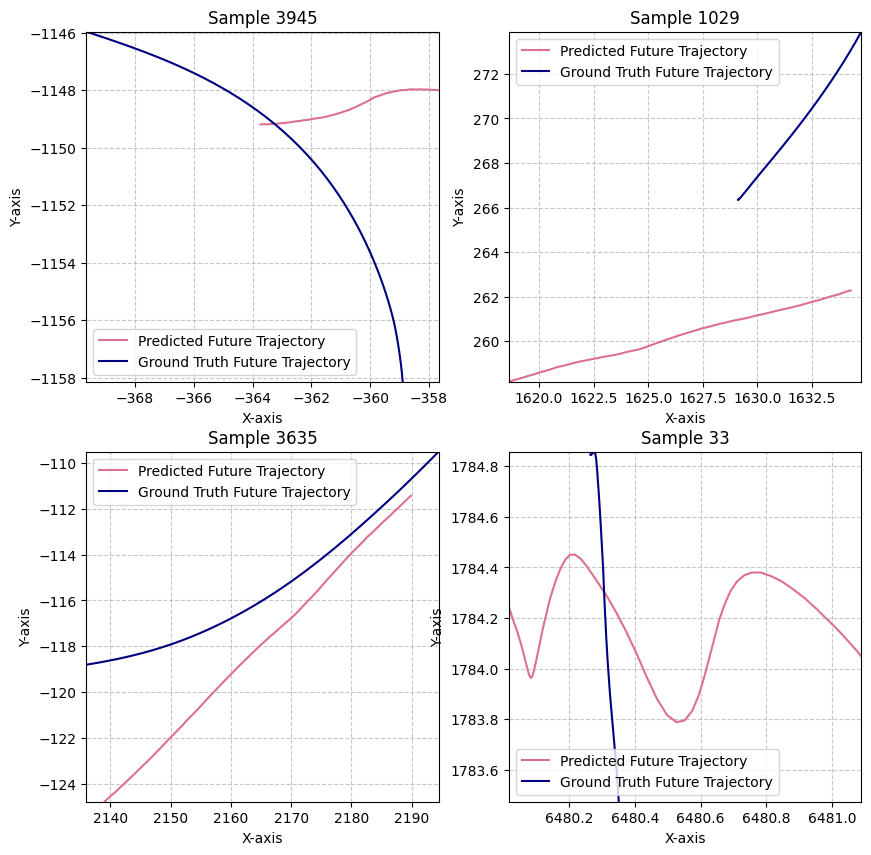

In [62]:
model = get_model()
if not isinstance(model, SceneContextModel):
    # LSTM can handle the timeseries data directly
    # TrajectoryDataset expects numpy arrays
    collate_func = lambda x: Batch.from_data_list(x)
    train_dataset = TrajectoryDatasetTrain(train_data, scale=scale, augment=True)
else:
    train_x: np.ndarray = train_data[..., :50, :]
    train_y: np.ndarray = train_data[:, 0, 50:, :2]
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

visualize_predictions(model, train_dataset)